In [6]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [7]:
df = pd.read_parquet('resources/extended_dataset.parquet').set_index('Inspection ID')
df.head(2)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,...,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27,[None],0,0,0,0
2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,...,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,"[3, 5, 25, 50, 53, 53, 56, 58]",8,2,1,5


In [8]:
df['Inspection Type'].unique()

array(['Complaint', 'License', 'Canvass', 'Others',
       'Suspect food poisoning', 'Cancelled', 'Consultation', 'Unknown',
       'Task-force'], dtype=object)

In [9]:
df['Facility Type'].unique()

array(['Restaurant', 'Childrens services facility', 'Daycare (2-6 yo)',
       'Grocery store', 'Daycare (0-6 yo)', 'Liquor store', 'Caterer',
       'Mobile food dispenser', 'Sweetshop', 'Bakery', 'Tavern',
       'Long term care center', 'Unknown', 'Others', 'School',
       'Banquet hall', 'Golden Dinner', 'Hospital', 'Daycare (0-2 yo)',
       'Daycare (others)', 'Gas station', 'Wholesaler', 'Shared kitchen',
       'Rooftop', 'Coffee shop', 'Shelter'], dtype=object)

In [10]:
df['Results'] = df['Results'].map(lambda x: x if x != 'Pass w/ Conditions' else 'Pass')
df['Results'].unique()

array(['Pass', 'Fail', 'Not Ready', 'No Entry', 'Out of Business',
       'Business Not Located'], dtype=object)

In [11]:
facility_types_to_keep = ['Restaurant', 'Coffe shop', 'Tavern', 'Rooftop']
results_to_keep = ['Fail', 'Pass']
old_len = len(df)
df = df.dropna(subset=['AKA Name'])
df = df[df['Re-inspection'] == False]
df = df[df['Facility Type'].map(lambda x: x in facility_types_to_keep)]
df = df[df['Results'].map(lambda x: x in results_to_keep)]
df = df[df['Inspection Type'] != 'Cancelled']
print('We have thrown away {}% of the inspections'.format((1 - len(df)/old_len) * 100))

We have thrown away 54.067467040614716% of the inspections


In [12]:
def remove_special_chars(string):
    return ''.join(e for e in string if e.isalnum()).upper()

def standardize_names(string):
    if 'MCDONALDS' in string:
        return 'MCDONALDS'
    elif 'SUBWAY' in string:
        return 'SUBWAY'
    elif 'POTBELLYSANDWICH' in string:
        return 'POTBELLYSANDWICH'
    elif 'POPEYES' in string:
        return 'POPEYES'
    elif 'DUNKINDONUTS' in string:
        return 'DUNKINDONUTS'
    elif 'BURGERKING' in string:
        return 'BURGERKING'
    elif 'WENDYS' in string:
        return 'WENDYS'
    elif 'STARBUCKS' in string:
        return 'STARBUCKS'
    elif 'PIZZAHUT' in string:
        return 'PIZZAHUT'
    elif 'KFC' in string or 'KENTUCKYFRIEDCHICKEN' in string:
        return 'KFC'
    elif 'HAROLDSCHICKEN' in string:
        return 'HAROLDSCHICKEN'
    elif '7ELEVEN' in string:
        return '7ELEVEN'
    elif 'JJFISH' in string:
        return 'JJFISH'
    return string

In [13]:
df['AKA Name'] = df['AKA Name'].map(lambda x: standardize_names(remove_special_chars(x)) if x is not None else None)

In [14]:
nb_locations_by_aka_dict = {}
for name in df['AKA Name'].unique():
    nb_uniques = len(df[df['AKA Name'] == name].groupby('Address'))
    nb_locations_by_aka_dict[name] = nb_uniques

In [15]:
nb_locations_by_aka = pd.DataFrame(nb_locations_by_aka_dict.items(), columns=['AKA Name', 'Nb Addresses']).set_index('AKA Name').sort_values('Nb Addresses', ascending=False)
nb_locations_by_aka.head(10)

,Nb Addresses
AKA Name,
SUBWAY,296
DUNKINDONUTS,228
STARBUCKS,184
MCDONALDS,122
BURGERKING,58
HAROLDSCHICKEN,50
POTBELLYSANDWICH,48
POPEYES,42
JIMMYJOHNS,42


In [16]:
old_len = len(df)
df = df[df['AKA Name'].map(lambda x: nb_locations_by_aka.loc[x]['Nb Addresses'] >= 2)]
print('We have, once more, thrown away {}% of the inspections'.format((1 - len(df)/old_len) * 100))

We have, once more, thrown away 66.83161012813383% of the inspections


In [17]:
nb_inspections_by_aka = df[['AKA Name', 'DBA Name']].groupby('AKA Name').count().rename(columns={'DBA Name' : 'Nb Inspections'}).sort_values('Nb Inspections', ascending=False)
nb_passed_inspections_by_aka = df[df['Results'] == 'Pass'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Passed Inspections'})
nb_failed_inspections_by_aka = df[df['Results'] == 'Fail'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Failed Inspections'})
mean_nb_violations_by_aka = df[['AKA Name', 'Nb Violations']].groupby('AKA Name').mean().rename(columns={'Nb Violations' : 'Mean Nb Violations'})
mean_nb_high_violations_by_aka = df[['AKA Name', 'Nb Violations of high severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of high severity' : 'Mean Nb Violations of high severity'})
mean_nb_medium_violations_by_aka = df[['AKA Name', 'Nb Violations of medium severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of medium severity' : 'Mean Nb Violations of medium severity'})
mean_nb_low_violations_by_aka = df[['AKA Name', 'Nb Violations of low severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of low severity' : 'Mean Nb Violations of low severity'})

In [18]:
import collections

def retrieve_violation_ids(serie):
    result = {}
    for violation_ids in serie:
        for violation_id in violation_ids:
            if violation_id != 'None':
                violation_id = int(violation_id)
                if violation_id in result:
                    result[violation_id] += 1
                else:
                    result[violation_id] = 1
    return collections.OrderedDict(sorted(result.items()))

violations_ids_by_aka = df[['AKA Name', 'Violation IDs']].groupby('AKA Name').agg(lambda x: retrieve_violation_ids(x)).rename(columns={'Violation IDs' : 'Dist Violation IDs'})
violations_ids_by_aka.head()

,Dist Violation IDs
AKA Name,
11DINING,"{2: 1, 3: 1, 5: 2, 10: 1, 21: 1, 33: 2, 35: 1,..."
1520LOUNGE,"{2: 1, 18: 4, 21: 1, 22: 1, 28: 1, 29: 1, 32: ..."
1CHOPSUEY,"{2: 2, 3: 3, 5: 2, 6: 1, 10: 1, 11: 2, 12: 1, ..."
5411EMPANADAS,"{1: 1, 2: 4, 3: 7, 5: 4, 8: 1, 10: 2, 11: 2, 1..."
65POKE,"{16: 1, 36: 1}"


In [19]:
df_joined = nb_inspections_by_aka.join(nb_locations_by_aka).join(nb_passed_inspections_by_aka.join(nb_failed_inspections_by_aka)).join(mean_nb_violations_by_aka.join(mean_nb_high_violations_by_aka).join(mean_nb_medium_violations_by_aka).join(mean_nb_low_violations_by_aka)).join(violations_ids_by_aka)
df_joined['Mean Nb Inspections'] = df_joined['Nb Inspections'] / df_joined['Nb Addresses']
df_joined['Mean Percent Passed Inspections'] = ((df_joined['Nb Passed Inspections'] / df_joined['Nb Addresses']) / df_joined['Mean Nb Inspections'] * 100).fillna(0.0)
df_joined['Mean Percent Failed Inspections'] = 100 - df_joined['Mean Percent Passed Inspections']
df_joined = df_joined.drop(['Nb Passed Inspections', 'Nb Failed Inspections'], axis=1)

def size_category(nb_addresses):
    if nb_addresses >= 100:
        return 'Huge'
    if nb_addresses >= 20:
        return 'Large'
    elif nb_addresses >= 5:
        return 'Medium'
    else:
        return 'Small'
    
df_joined['Size'] = df_joined['Nb Addresses'].map(size_category)

df_joined.head(10)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,
SUBWAY,3239,296,2.931460,0.354122,0.332819,2.244520,"{1: 24, 2: 162, 3: 448, 4: 11, 5: 191, 6: 53, ...",10.942568,83.976536,16.023464,Huge
DUNKINDONUTS,1831,228,3.416712,0.294921,0.364828,2.756963,"{1: 12, 2: 89, 3: 164, 4: 3, 5: 62, 6: 52, 7: ...",8.030702,80.939377,19.060623,Huge
MCDONALDS,1606,122,3.415940,0.262765,0.283313,2.869863,"{1: 2, 2: 60, 3: 122, 4: 7, 5: 37, 6: 30, 7: 1...",13.163934,78.767123,21.232877,Huge
STARBUCKS,1107,184,2.368564,0.178862,0.228546,1.961156,"{1: 5, 2: 25, 3: 58, 4: 2, 5: 41, 6: 3, 8: 17,...",6.016304,85.275519,14.724481,Huge
BURGERKING,545,58,3.823853,0.308257,0.390826,3.124771,"{1: 2, 2: 13, 3: 50, 4: 2, 5: 30, 6: 10, 7: 1,...",9.396552,79.816514,20.183486,Large
POPEYES,522,42,3.929119,0.327586,0.285441,3.316092,"{1: 1, 2: 15, 3: 56, 4: 1, 5: 43, 6: 6, 8: 4, ...",12.428571,79.501916,20.498084,Large
POTBELLYSANDWICH,475,48,3.568421,0.305263,0.298947,2.964211,"{1: 1, 2: 28, 3: 53, 4: 2, 5: 23, 6: 8, 8: 2, ...",9.895833,79.789474,20.210526,Large
KFC,389,36,3.976864,0.285347,0.316195,3.375321,"{2: 14, 3: 34, 4: 2, 5: 22, 6: 6, 8: 2, 9: 4, ...",10.805556,78.663239,21.336761,Large
CHIPOTLEMEXICANGRILL,359,25,2.484680,0.211699,0.281337,1.991643,"{2: 11, 3: 45, 5: 3, 6: 7, 7: 1, 8: 2, 9: 1, 1...",14.360000,84.122563,15.877437,Large


## What is the distribution of the size categories ? ##

,Dist Size
Size,
Huge,4
Large,15
Medium,95
Small,923


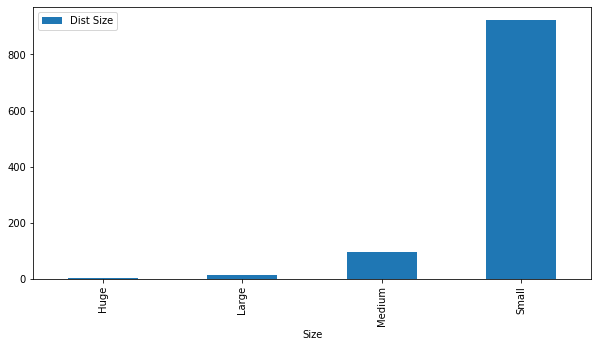

In [20]:
df_sizes = df_joined[['Size', 'Nb Inspections']].groupby('Size').count().rename(columns={'Nb Inspections' : 'Dist Size'})
df_sizes.plot.bar()
df_sizes

In [21]:
df_joined.groupby('Size').median()

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections
Size,,,,,,,,,
Huge,1718.5,206.0,3.173700,0.278843,0.308066,2.500742,9.486635,82.457957,17.542043
Large,334.0,33.0,3.355932,0.307692,0.372470,2.604790,8.119048,79.789474,20.210526
Medium,44.0,6.0,3.500000,0.366667,0.372093,2.750000,6.666667,78.378378,21.621622
Small,12.0,2.0,4.250000,0.400000,0.400000,3.333333,5.500000,75.862069,24.137931


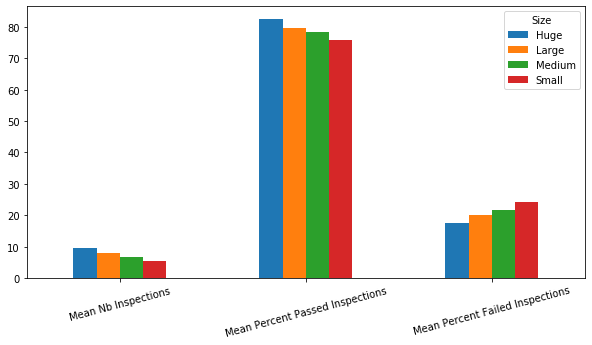

In [22]:
df_joined[['Size', 'Mean Nb Inspections', 'Mean Percent Passed Inspections', 'Mean Percent Failed Inspections']].groupby('Size').median().transpose().plot.bar(rot=15)

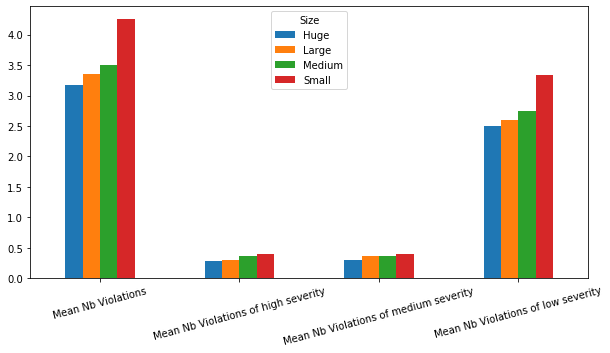

In [23]:
df_joined[['Size', 'Mean Nb Violations', 'Mean Nb Violations of high severity', 'Mean Nb Violations of medium severity', 'Mean Nb Violations of low severity']].groupby('Size').median().transpose().plot.bar(rot=15)

## Which ones have more addresses ? ##

In [24]:
df_joined.sort_values('Nb Addresses', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,
SUBWAY,3239,296,2.931460,0.354122,0.332819,2.244520,"{1: 24, 2: 162, 3: 448, 4: 11, 5: 191, 6: 53, ...",10.942568,83.976536,16.023464,Huge
DUNKINDONUTS,1831,228,3.416712,0.294921,0.364828,2.756963,"{1: 12, 2: 89, 3: 164, 4: 3, 5: 62, 6: 52, 7: ...",8.030702,80.939377,19.060623,Huge
STARBUCKS,1107,184,2.368564,0.178862,0.228546,1.961156,"{1: 5, 2: 25, 3: 58, 4: 2, 5: 41, 6: 3, 8: 17,...",6.016304,85.275519,14.724481,Huge
MCDONALDS,1606,122,3.415940,0.262765,0.283313,2.869863,"{1: 2, 2: 60, 3: 122, 4: 7, 5: 37, 6: 30, 7: 1...",13.163934,78.767123,21.232877,Huge
BURGERKING,545,58,3.823853,0.308257,0.390826,3.124771,"{1: 2, 2: 13, 3: 50, 4: 2, 5: 30, 6: 10, 7: 1,...",9.396552,79.816514,20.183486,Large
HAROLDSCHICKEN,344,50,4.412791,0.357558,0.494186,3.561047,"{1: 3, 2: 23, 3: 41, 5: 15, 6: 6, 9: 2, 10: 12...",6.880000,67.441860,32.558140,Large
POTBELLYSANDWICH,475,48,3.568421,0.305263,0.298947,2.964211,"{1: 1, 2: 28, 3: 53, 4: 2, 5: 23, 6: 8, 8: 2, ...",9.895833,79.789474,20.210526,Large
POPEYES,522,42,3.929119,0.327586,0.285441,3.316092,"{1: 1, 2: 15, 3: 56, 4: 1, 5: 43, 6: 6, 8: 4, ...",12.428571,79.501916,20.498084,Large
JIMMYJOHNS,341,42,2.806452,0.401760,0.401760,2.002933,"{1: 2, 2: 22, 3: 42, 4: 1, 5: 29, 6: 12, 8: 3,...",8.119048,82.111437,17.888563,Large


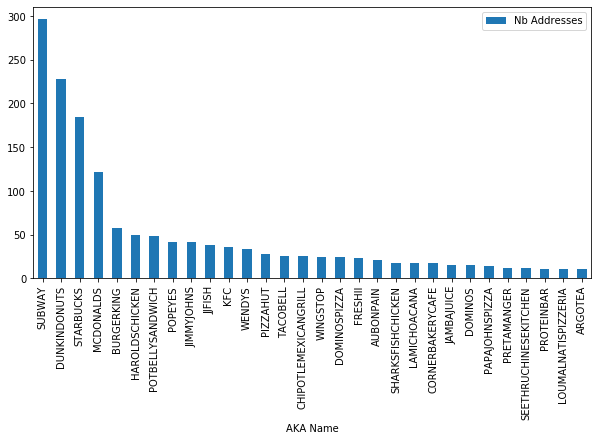

In [25]:
df_joined[['Nb Addresses']].sort_values('Nb Addresses', ascending=False).head(30).plot.bar()

## Which ones have more inspections in general ? ##

In [26]:
df_joined.sort_values('Mean Nb Inspections', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,
BJSMARKETBAKERY,45,2,5.555556,0.488889,0.488889,4.577778,"{2: 3, 3: 8, 5: 4, 9: 1, 10: 5, 11: 1, 16: 1, ...",22.500000,73.333333,26.666667,Small
SEETHRUCHINESERESTAURANT,42,2,4.595238,0.214286,0.500000,3.880952,"{2: 1, 3: 4, 4: 1, 5: 2, 11: 1, 16: 6, 18: 7, ...",21.000000,69.047619,30.952381,Small
GOLDCOASTDOGS,35,2,2.914286,0.285714,0.228571,2.400000,"{1: 1, 2: 3, 3: 4, 5: 1, 10: 1, 16: 1, 18: 1, ...",17.500000,91.428571,8.571429,Small
PORTILLOSHOTDOGS,35,2,3.028571,0.314286,0.314286,2.400000,"{2: 2, 3: 2, 5: 1, 6: 2, 8: 1, 10: 2, 12: 1, 1...",17.500000,80.000000,20.000000,Small
GOLDENNUGGETPANCAKEHOUSE,34,2,4.000000,0.558824,0.147059,3.294118,"{2: 4, 3: 5, 5: 1, 6: 1, 8: 3, 10: 3, 11: 1, 1...",17.000000,91.176471,8.823529,Small
NUEVOLEONRESTAURANT,33,2,7.242424,0.666667,0.939394,5.636364,"{2: 6, 3: 8, 4: 1, 5: 2, 6: 2, 10: 2, 11: 1, 1...",16.500000,60.606061,39.393939,Small
WHALEFISHANDCHICKEN,32,2,3.406250,0.156250,0.187500,3.062500,"{3: 2, 5: 1, 11: 1, 12: 1, 16: 1, 18: 3, 21: 1...",16.000000,81.250000,18.750000,Small
MAXWELLSTREETGRILL,31,2,3.290323,0.193548,0.161290,2.935484,"{2: 1, 3: 3, 5: 1, 9: 1, 18: 2, 21: 1, 22: 1, ...",15.500000,90.322581,9.677419,Small
BAKERSSQUARE,46,3,5.717391,0.543478,0.565217,4.608696,"{2: 3, 3: 10, 5: 2, 6: 2, 8: 3, 10: 4, 12: 1, ...",15.333333,67.391304,32.608696,Small


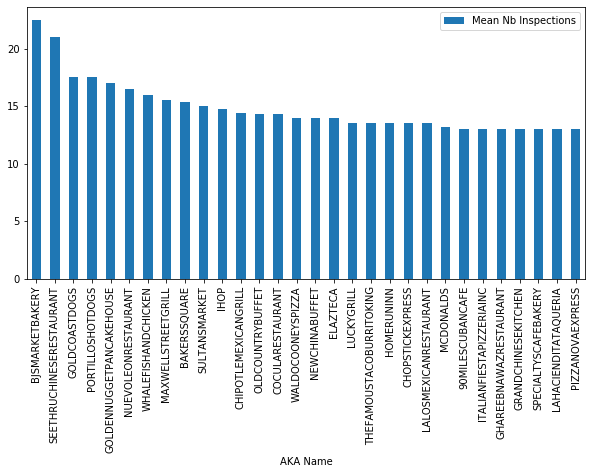

In [27]:
df_joined[['Mean Nb Inspections']].sort_values('Mean Nb Inspections', ascending=False).head(30).plot.bar()

([], <a list of 0 Text xticklabel objects>)

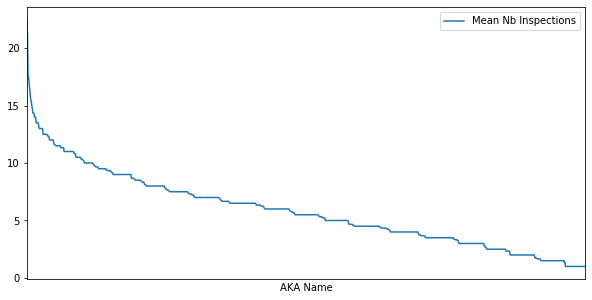

In [28]:
df_joined[['Mean Nb Inspections']].sort_values('Mean Nb Inspections', ascending=False).plot()
plt.xticks([])

## Which ones tend to easily pass inspections ? ##

In [29]:
df_joined.sort_values('Mean Percent Passed Inspections', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,
LEONASPIZZA,5,3,1.200000,0.200000,0.200000,0.800000,"{3: 1, 25: 1, 47: 1, 49: 2, 58: 1}",1.666667,100.0,0.0,Small
PASTAANDBURGERSALON,3,2,1.666667,0.000000,0.333333,1.333333,"{21: 1, 35: 2, 38: 2}",1.500000,100.0,0.0,Small
LIFEWAYKEFIRSHOP,14,3,2.642857,0.714286,0.071429,1.857143,"{2: 1, 3: 4, 5: 4, 10: 1, 21: 1, 31: 1, 32: 2,...",4.666667,100.0,0.0,Small
THEREDHEADPIANOBAR,3,2,1.333333,0.666667,0.000000,0.666667,"{3: 1, 5: 1, 34: 1, 41: 1}",1.500000,100.0,0.0,Small
THEWINDSOR,14,2,4.428571,0.714286,0.428571,3.285714,"{3: 3, 5: 3, 9: 2, 10: 2, 21: 2, 23: 1, 25: 2,...",7.000000,100.0,0.0,Small
CAMINOALASALUD,7,2,1.857143,0.285714,0.428571,1.142857,"{3: 1, 5: 1, 21: 3, 34: 1, 35: 2, 38: 2, 40: 1...",3.500000,100.0,0.0,Small
PHILLYBROS,7,2,7.142857,1.285714,0.571429,5.285714,"{3: 3, 5: 3, 10: 3, 21: 1, 23: 2, 25: 1, 32: 2...",3.500000,100.0,0.0,Small
REDMANGOCAFE,3,2,2.000000,0.000000,0.000000,2.000000,"{30: 1, 33: 1, 34: 2, 35: 1, 41: 1}",1.500000,100.0,0.0,Small
TEXASDEBRAZIL,14,2,3.071429,0.214286,0.071429,2.785714,"{2: 1, 3: 1, 9: 1, 21: 1, 30: 2, 31: 2, 32: 2,...",7.000000,100.0,0.0,Small


([], <a list of 0 Text xticklabel objects>)

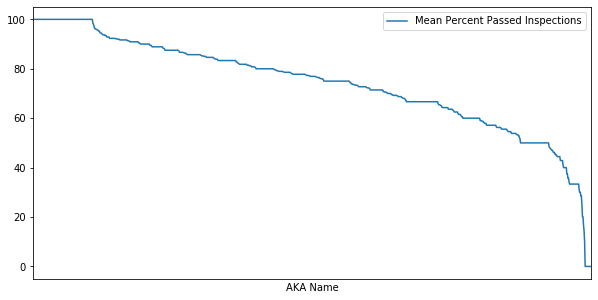

In [30]:
df_joined[['Mean Percent Passed Inspections']].sort_values('Mean Percent Passed Inspections', ascending=False).plot()
plt.xticks([])

## Which ones tend to fail inspections ? ##

In [31]:
df_joined.sort_values('Mean Percent Failed Inspections', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,
RAYEESCAFE,2,2,7.000000,0.000000,1.500000,5.500000,"{18: 2, 24: 1, 32: 2, 34: 1, 35: 2, 37: 1, 38:...",1.0,0.000000,100.000000,Small
MARKOSTACOSCAFE,3,2,8.000000,0.000000,0.666667,7.333333,"{18: 1, 24: 1, 30: 2, 31: 1, 32: 2, 33: 2, 34:...",1.5,0.000000,100.000000,Small
MISKASLIQUORDELI,2,2,2.500000,0.500000,1.000000,1.000000,"{2: 1, 18: 2, 38: 2}",1.0,0.000000,100.000000,Small
CHINESEROYALKITCHEN,4,2,8.250000,0.500000,1.250000,6.500000,"{6: 1, 11: 1, 18: 3, 19: 1, 24: 1, 30: 2, 32: ...",2.0,0.000000,100.000000,Small
CHICAGOSTEAKWINGS,3,2,8.333333,0.666667,1.000000,6.666667,"{2: 1, 9: 1, 18: 2, 21: 1, 30: 2, 32: 2, 33: 3...",1.5,0.000000,100.000000,Small
KINTERCONTINENTALRESTAURANT,2,2,5.000000,0.000000,1.500000,3.500000,"{18: 1, 19: 1, 24: 1, 33: 1, 34: 2, 36: 1, 38:...",1.0,0.000000,100.000000,Small
POMPEI,7,2,8.857143,1.571429,1.714286,5.571429,"{2: 4, 3: 4, 4: 1, 6: 1, 11: 1, 18: 7, 19: 1, ...",3.5,0.000000,100.000000,Small
1520LOUNGE,5,2,5.000000,0.200000,1.600000,3.200000,"{2: 1, 18: 4, 21: 1, 22: 1, 28: 1, 29: 1, 32: ...",2.5,0.000000,100.000000,Small
EMPORIUMARCADEBAR,2,2,4.500000,0.500000,1.500000,2.500000,"{12: 1, 18: 2, 19: 1, 35: 1, 38: 2, 41: 1, 43: 1}",1.0,0.000000,100.000000,Small


([], <a list of 0 Text xticklabel objects>)

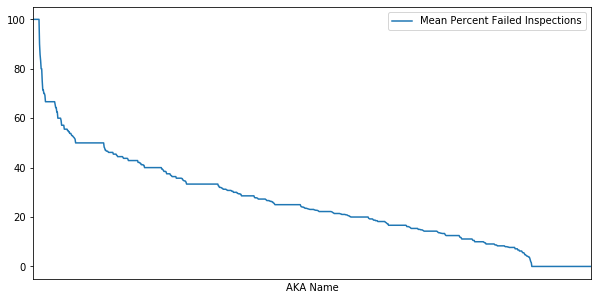

In [32]:
df_joined[['Mean Percent Failed Inspections']].sort_values('Mean Percent Failed Inspections', ascending=False).plot()
plt.xticks([])

## Which ones have more violations by inspections ? ##

In [33]:
df_joined.sort_values('Mean Nb Violations', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,
THEGAME,3,2,12.333333,2.000000,2.333333,8.000000,"{2: 2, 9: 2, 11: 2, 18: 2, 21: 3, 24: 2, 32: 2...",1.500000,33.333333,66.666667,Small
MSBSKITCHENCATERING,2,2,10.000000,1.000000,0.500000,8.500000,"{3: 1, 5: 1, 23: 1, 31: 1, 33: 1, 38: 1, 39: 1...",1.000000,50.000000,50.000000,Small
RENALDISPIZZA,14,2,9.500000,2.142857,1.142857,6.214286,"{1: 1, 2: 4, 3: 10, 4: 3, 5: 1, 9: 3, 10: 4, 1...",7.000000,42.857143,57.142857,Small
JERKTACOMAN,20,3,9.300000,1.350000,1.350000,6.600000,"{2: 3, 3: 10, 5: 5, 8: 2, 9: 2, 10: 4, 12: 1, ...",6.666667,45.000000,55.000000,Small
BABASHALAL,2,2,9.000000,2.000000,0.000000,7.000000,"{3: 2, 5: 2, 33: 1, 38: 2, 47: 1, 48: 1, 55: 4...",1.000000,50.000000,50.000000,Small
KHANBBQRESTAURANT,17,2,8.882353,0.823529,1.000000,7.058824,"{2: 1, 3: 6, 5: 3, 6: 1, 8: 2, 12: 1, 16: 2, 1...",8.500000,58.823529,41.176471,Small
POMPEI,7,2,8.857143,1.571429,1.714286,5.571429,"{2: 4, 3: 4, 4: 1, 6: 1, 11: 1, 18: 7, 19: 1, ...",3.500000,0.000000,100.000000,Small
CORNERSTONECAFE,16,2,8.625000,1.000000,1.250000,6.375000,"{1: 2, 2: 2, 3: 3, 5: 2, 6: 1, 8: 3, 10: 1, 11...",8.000000,62.500000,37.500000,Small
KINGPHOPLUS,5,2,8.600000,0.800000,0.800000,7.000000,"{3: 2, 5: 2, 16: 1, 23: 1, 24: 1, 25: 1, 30: 1...",2.500000,40.000000,60.000000,Small


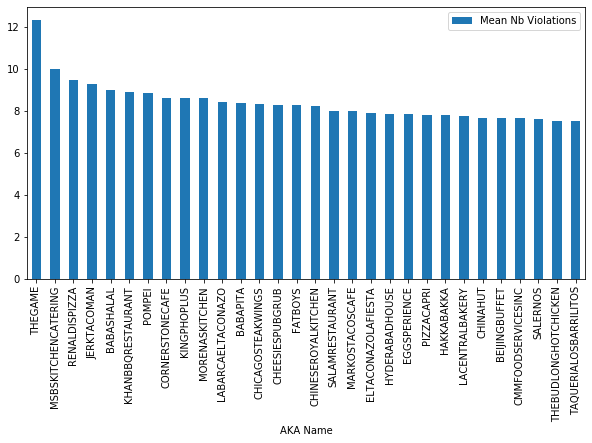

In [34]:
df_joined[['Mean Nb Violations']].sort_values('Mean Nb Violations', ascending=False).head(30).plot.bar()

([], <a list of 0 Text xticklabel objects>)

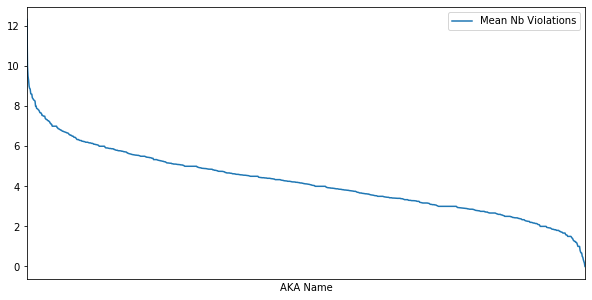

In [35]:
df_joined[['Mean Nb Violations']].sort_values('Mean Nb Violations', ascending=False).plot()
plt.xticks([])

## How does the violations' distribution change depending on the size ? ##

In [62]:
violations = pd.read_csv('resources/violation-id-meaning.csv').set_index('Violation ID')
violations.head()

,Meaning,Category,Severity
Violation ID,,,
1,Suspicious source,Food safety,High
2,No adequate food storage,Food safety,High
3,Food storage temperature problems,Food safety,High
4,Contamination,Food safety,High
5,Disease among the staff,Hygiene,High


In [66]:
def regroup_violation_dists(dists):
    result = {}
    for dist in dists:
        for key, value in dist.items():
            if key in result:
                result[key] += value
            else:
                result[key] = value
    return collections.OrderedDict(sorted(result.items()))

def regroup_ids_in_categories(dist, severity=None):
    result = {}
    total = 0
    for key, value in dist.items():
        if key in violations.index:
            key_severity = violations.loc[key]['Severity']
            category = violations.loc[key]['Category']
        else:
            key_severity = 'Small'
            category = 'Other'
        if key_severity == severity or severity is None:
            if category in result:
                result[category] += value
            else:
                result[category] = value
            total += value
    for key in result.keys():
        result[key] /= total
        result[key] *= 100
    return collections.OrderedDict(sorted(result.items()))
            

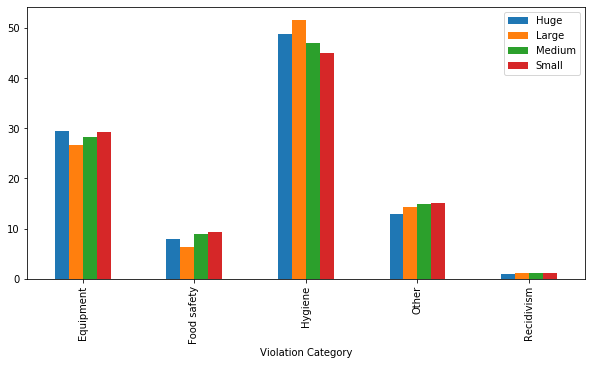

In [67]:
list_dists = []
for size in ['Huge', 'Large', 'Medium', 'Small']:
    dist = regroup_violation_dists(df_joined[df_joined['Size'] == size]['Dist Violation IDs'].values)    
    dist_categories = regroup_ids_in_categories(dist)
    df_dist_categories = pd.DataFrame(dist_categories.items(), columns=['Violation Category', size]).set_index('Violation Category')
    list_dists.append(df_dist_categories)
pd.concat(list_dists, axis=1).plot.bar()

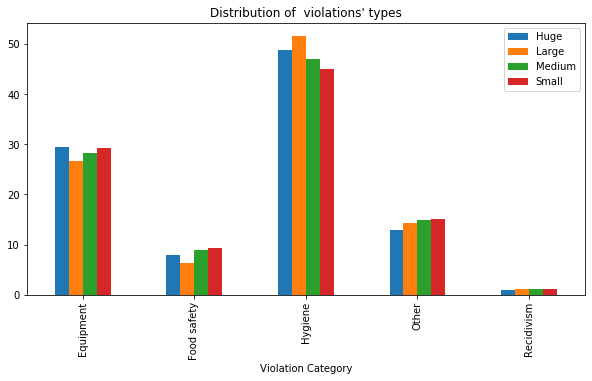

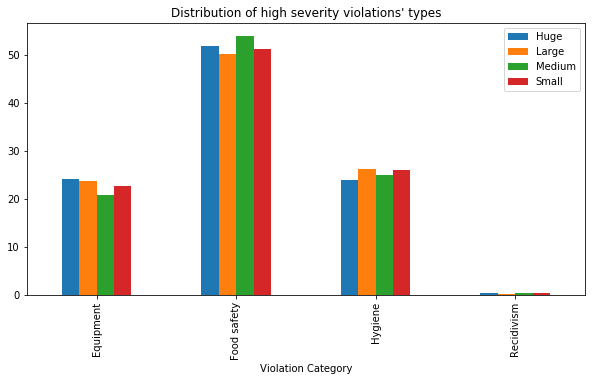

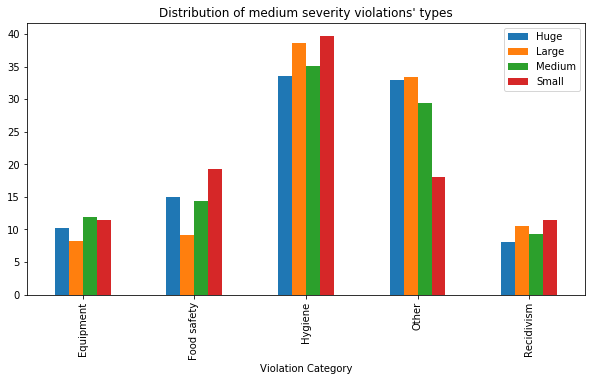

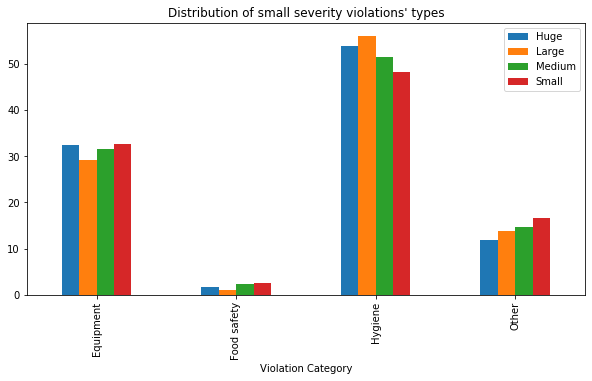

In [88]:
for severity in [None, 'High', 'Medium', 'Small']:
    list_dists = []
    for size in ['Huge', 'Large', 'Medium', 'Small']:
        dist = regroup_violation_dists(df_joined[df_joined['Size'] == size]['Dist Violation IDs'].values)    
        dist_categories = regroup_ids_in_categories(dist, severity=severity)
        df_dist_categories = pd.DataFrame(dist_categories.items(), columns=['Violation Category', size]).set_index('Violation Category')
        list_dists.append(df_dist_categories)
    pd.concat(list_dists, axis=1).plot.bar()
    plt.title("Distribution of {} violations' types".format(severity.lower() + " severity" if severity is not None else ''))

## What are the violations distributions for the main ones ? ##

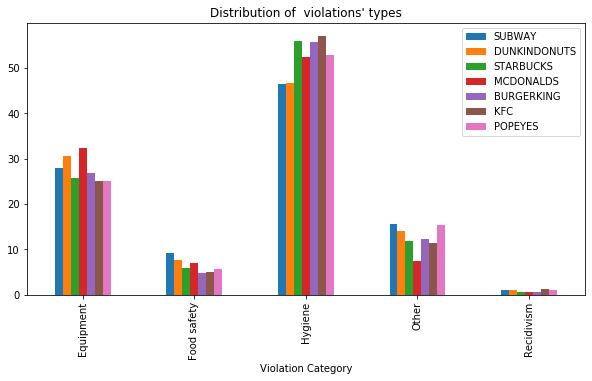

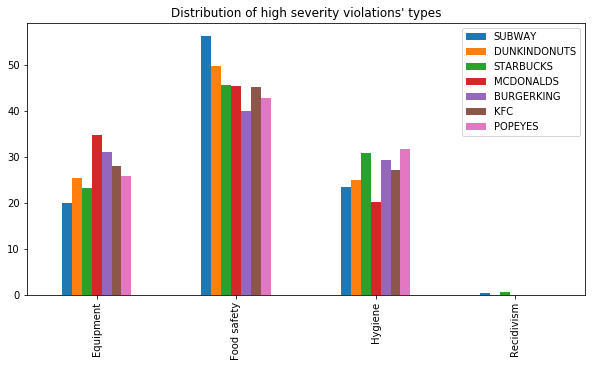

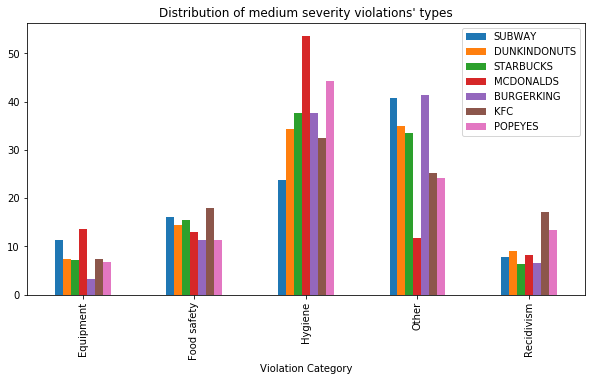

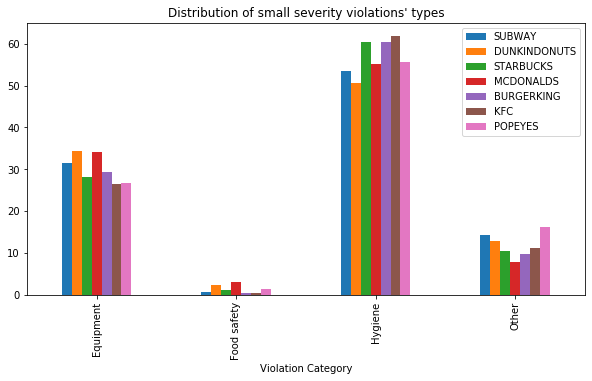

In [90]:
interesting_aka_names = ['SUBWAY', 'DUNKINDONUTS', 'STARBUCKS', 'MCDONALDS', 'BURGERKING', 'KFC', 'POPEYES']
for severity in [None, 'High', 'Medium', 'Small']:
    list_dists = []
    for name in interesting_aka_names:
        dist = df_joined.loc[name]['Dist Violation IDs']
        dist_categories = regroup_ids_in_categories(dist, severity=severity)
        df_dist_categories = pd.DataFrame(dist_categories.items(), columns=['Violation Category', name]).set_index('Violation Category')
        list_dists.append(df_dist_categories)
    pd.concat(list_dists, axis=1, sort=True).plot.bar()
    plt.title("Distribution of {} violations' types".format(severity.lower() + " severity" if severity is not None else ''))